In [1]:
!pip install gudhi
!pip install hdbscan
!pip install genieclust
!pip install ete3 zss scipy
from scipy.spatial import distance
import plotly.graph_objects as go
import networkx as nx
import matplotlib.pyplot as plt
from pprint import pprint
from numpy.linalg import matrix_rank
import numpy as np
import gudhi as gd
import matplotlib
import scipy.spatial as spatial
import bisect
import matplotlib
from scipy.cluster import hierarchy
from urllib.request import urlopen
from io import BytesIO
from gudhi import AlphaComplex
from scipy.spatial.distance import cdist
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import ward, fcluster
from sklearn.cluster import KMeans
from sklearn.neighbors import KernelDensity
from sklearn.metrics.cluster import adjusted_rand_score
from scipy.cluster.hierarchy import dendrogram
import time
from scipy.spatial import KDTree
from sklearn.datasets import make_blobs
from sklearn.metrics import calinski_harabasz_score
import pandas as pd
import random
from sklearn.cluster import DBSCAN
import hdbscan
from gudhi.clustering.tomato import Tomato
import genieclust
from scipy.spatial.distance import pdist
from sklearn import metrics
from sklearn.mixture import GaussianMixture

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 36.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for ete3: filename=ete3-3.1.3-py3-none-any.whl size=2273786 sha256=bf37ec2bc0e2de898b5dcef15457bfe66a2ef5cf0e473a3b0b46c5df903c19e0
  Stored in directory: /root/.cache/pip/wheels/dd/a8/60/0a29caa9f8ceb7316704be63c1578ab13c36668abb646366ac
  Created wheel for zss: filename=zss-1.2.0-py3-none-any.whl size=6725 sha256=bc345a16c091804ad4e1c8767a4b11341f10bf5df322b0e343db6f7f4ee30549
  Stored in directory: /root/.cache/pip/wheels/e8/3a/21/9f03c8002063200de26717429ca1543466c5feec134a0a73ff
Successfully built ete3 zss


In [70]:
import numpy as np
from scipy.spatial.distance import cdist
from sklearn.neighbors import KDTree, NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import PolynomialFeatures
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt

class FiltrationBuilder:
    def __init__(self, data):
        self.data = data

    def get_filtration(self, dist):
        filtration = []
        for i in range(len(self.data)):
            for j in range(len(self.data)):
                if i > j:
                    continue
                elif i == j:
                    filtration.append(([i], dist[i][j]))
                else:
                    filtration.append(([i, j], dist[i][j]))
        filtration = sorted(filtration, key=lambda x: (x[1], x[0]))
        return self.transform_filtration(filtration)

    def transform_filtration(self, filtration):
        new_filtration = []
        new_filtration.append(filtration[0])
        if filtration[1][1] == filtration[0][1]:
            new_filtration.append((filtration[1][0], filtration[1][1] + 1e-15))
        else:
            new_filtration.append(filtration[1])
        for i in range(2, len(filtration)):
            if filtration[i][1] == filtration[i-1][1] and filtration[i][1] == filtration[i-2][1]:
                new_filtration.append((filtration[i][0], new_filtration[-1][1] + 1e-15))
            elif filtration[i][1] == filtration[i-1][1]:
                new_filtration.append((filtration[i][0], filtration[i-1][1] + 1e-15))
            else:
                new_filtration.append(filtration[i])
        return new_filtration

    def get_filtration_from_scipy_dist(self, dist_type):
        dist = cdist(self.data, self.data, dist_type)
        return self.get_filtration(dist)

    def get_filtration_from_density(self, kernel_type, bandwidth):
        kde = KernelDensity(kernel=kernel_type, bandwidth=bandwidth).fit(self.data)
        point_density = np.exp(kde.score_samples(self.data)).tolist()
        maximum = np.max(np.exp(kde.score_samples(self.data)))
        second_maximum = np.sort(np.exp(kde.score_samples(self.data)))[-2]
        dist = [[0 for _ in range(len(self.data))] for _ in range(len(self.data))]
        for i in range(len(self.data)):
            for j in range(len(self.data)):
                if i < j:
                    dist[i][j] = abs(point_density[i] - point_density[j])
                    dist[j][i] = dist[i][j]
        return self.get_filtration(dist)

    def get_not_normalized_filtration_from_density(self, r):
        tree = KDTree(self.data)
        densities = tree.query_ball_point(self.data, r)
        point_density = np.array([len(neighbors) for neighbors in densities])
        maximum = max(point_density)
        second_maximum = sorted(point_density)[-2]
        dist = [[0 for _ in range(len(self.data))] for _ in range(len(self.data))]
        for i in range(len(self.data)):
            for j in range(len(self.data)):
                if i < j:
                    dist[i][j] = abs(point_density[i] - point_density[j])
                    dist[j][i] = dist[i][j]
        return self.get_filtration(dist)

    def get_filtration_from_curvature(self):
        x = np.array(self.data)[:, 0]
        y = np.array(self.data)[:, 1]
        dx = np.gradient(x)
        dy = np.gradient(y)
        d2x = np.gradient(dx)
        d2y = np.gradient(dy)
        curvatures = np.abs(d2x * dy - dx * d2y) / (dx**2 + dy**2)**1.5
        dist = [[0 for _ in range(len(self.data))] for _ in range(len(self.data))]
        for i in range(len(self.data)):
            for j in range(len(self.data)):
                if i < j:
                    dist[i][j] = curvatures[i] + curvatures[j]
                    dist[j][i] = dist[i][j]
        return self.get_filtration(dist)

    def get_filtration_from_knn(self, k):
        nbrs = NearestNeighbors(n_neighbors=k).fit(self.data)
        distances, _ = nbrs.kneighbors(self.data)
        knn_distances = distances[:, -1]
        maximum = np.max(knn_distances)
        second_maximum = np.sort(knn_distances)[-2] if len(knn_distances) >= 2 else maximum
        dist = [[0.0 for _ in range(len(self.data))] for _ in range(len(self.data))]
        for i in range(len(self.data)):
            for j in range(len(self.data)):
                if i < j:
                    val = abs(knn_distances[i] - knn_distances[j])
                    dist[i][j] = val
                    dist[j][i] = val
        return self.get_filtration(dist)

    def get_filtration_from_christoffel(self, degree):
        N = len(self.data)
        poly = PolynomialFeatures(degree=degree, include_bias=True)
        V = poly.fit_transform(self.data)
        s = V.shape[1]
        res = V[0].reshape(-1, 1) @ V[0].reshape(1, -1)
        for i in range(1, len(V)):
            Vi = V[i].reshape(-1, 1)
            res += Vi @ Vi.T
        M_d = (1.0 / N) * res
        M_d_inv = np.linalg.pinv(M_d)
        Q = np.sum(V * (np.dot(V, M_d_inv)), axis=1)
        Lambda = 1.0 / Q
        christoffel_density = s * Lambda
        max_density = np.max(christoffel_density)
        second_max = np.sort(christoffel_density)[-2] if N >= 2 else max_density
        dist = [[0 for _ in range(len(self.data))] for _ in range(len(self.data))]
        for i in range(len(self.data)):
            for j in range(i+1, len(self.data)):
                val = abs(christoffel_density[i] - christoffel_density[j])
                dist[i][j] = val
                dist[j][i] = val
        return self.get_filtration(dist)

    def get_filtration_from_intrinsic_dim(self, k_neighbors=10, var_threshold=0.95):
        nbrs = NearestNeighbors(n_neighbors=k_neighbors + 1).fit(self.data)
        _, indices = nbrs.kneighbors(self.data)
        intrinsic_dims = []
        for idx_list in indices:
            X_local = self.data[idx_list[1:]]
            pca = PCA().fit(X_local)
            cum_var = np.cumsum(pca.explained_variance_ratio_)
            intrinsic_dims.append(np.searchsorted(cum_var, var_threshold) + 1)
        intrinsic_dims = np.array(intrinsic_dims)
        max_dim = np.max(intrinsic_dims)
        second_max = np.sort(intrinsic_dims)[-2] if len(intrinsic_dims) >= 2 else max_dim
        n = len(self.data)
        dist = [[0.0 for _ in range(n)] for _ in range(n)]
        nbrs = NearestNeighbors(n_neighbors=2 * k_neighbors).fit(self.data)
        _, indices = nbrs.kneighbors(self.data)
        for i in range(n):
            for j in range(i + 1, n):
                dim_diff = abs(intrinsic_dims[i] - intrinsic_dims[j])
                val = 10 * dim_diff
                if dim_diff == 0:
                    if j not in indices[i][1:]:
                        val += 8
                val += np.random.random() * 2
                dist[i][j] = val
                dist[j][i] = val
        for i in range(n):
            dist[i][i] = 0
        return self.get_filtration(dist)

class BifiltrationProcessor:
    def __init__(self, filtration1, filtration2):
        self.filtration1 = filtration1
        self.filtration2 = filtration2

    def critical_points(self):
        filtration1_dict, filtration2_dict = dict(), dict()
        filtration1_dict_rev, filtration2_dict_rev = dict(), dict()
        for i in range(len(self.filtration1)):
            filtration1_dict[tuple(self.filtration1[i][0])] = (self.filtration1[i][1], i)
            filtration1_dict_rev[i] = self.filtration1[i][0]
        for i in range(len(self.filtration2)):
            filtration2_dict[tuple(self.filtration2[i][0])] = (self.filtration2[i][1], i)
            filtration2_dict_rev[i] = self.filtration2[i][0]

        grid = [[-1 for i in range(len(self.filtration2))] for j in range(len(self.filtration1))]
        for item in filtration1_dict.items():
            grid[item[1][1]][filtration2_dict[item[0]][1]] = 0

        for i in range(len(grid)):
            for j in range(len(grid[0])):
                if (i != 0) and (j != 0) and grid[i - 1][j] == 0 and grid[i][j - 1] == 0:
                    grid[i][j] = 1
        return grid, filtration1_dict_rev, filtration2_dict_rev, filtration1_dict, filtration2_dict

    def get_slice(self, f, f_invers):
        grid, filtration1_dict_rev, filtration2_dict_rev, filtration1_dict, filtration2_dict = self.critical_points()

        prepared_filtration = []
        for x_grid in range(len(self.filtration1)):
            for y_grid in range(len(self.filtration2)):
                x_grid_val = self.filtration1[x_grid][1]
                y_grid_val = self.filtration2[y_grid][1]
                y_line = f(x_grid_val)
                x_line = f_invers(y_grid_val)
                if y_line <= y_grid_val:
                    if grid[x_grid][y_grid] == 0:
                        prepared_filtration.append((filtration1_dict_rev[x_grid], y_grid_val + x_line, x_line - x_grid_val))
                    elif grid[x_grid][y_grid] == 1:
                        prepared_filtration.append((filtration1_dict_rev[x_grid - 1], y_grid_val + x_line, x_line - x_grid_val))
                else:
                    if grid[x_grid][y_grid] == 0:
                        prepared_filtration.append((filtration2_dict_rev[y_grid], y_line + x_grid_val, y_line - y_grid_val))
                    elif grid[x_grid][y_grid] == 1:
                        prepared_filtration.append((filtration2_dict_rev[y_grid - 1], y_line + x_grid_val, y_line - y_grid_val))

        prepared_filtration = sorted(prepared_filtration, key= lambda x: (x[1], x[2]))
        filtration = []
        filtration.append((prepared_filtration[0][0], prepared_filtration[0][1]))
        for i in range(1, len(prepared_filtration)):
            if prepared_filtration[i][1] != prepared_filtration[i - 1][1]:
                filtration.append((prepared_filtration[i][0], prepared_filtration[i][1]))
        return filtration

    def get_slice_optimized(self, f, f_inverse):
        f1_dict = {tuple(simplex): (value, idx) for idx, (simplex, value) in enumerate(self.filtration1)}
        f2_dict = {tuple(simplex): (value, idx) for idx, (simplex, value) in enumerate(self.filtration2)}

        prepared_filtration = []

        for simplex, (value1, idx1) in f1_dict.items():
            if simplex in f2_dict:
                value2, idx2 = f2_dict[simplex]
                x_line = f_inverse(value2)
                y_line = f(value1)
                if y_line <= value2:
                    projected_value = value2 + x_line
                    dist = x_line - value1
                else:
                    projected_value = y_line + value1
                    dist = y_line - value2
                prepared_filtration.append((simplex, projected_value, dist))

        prepared_filtration.sort(key=lambda x: (x[1], x[2]))
        filtration = []
        for i in range(len(prepared_filtration)):
            if i == 0 or prepared_filtration[i][1] != prepared_filtration[i-1][1]:
                filtration.append((prepared_filtration[i][0], prepared_filtration[i][1]))

        return filtration


    def get_path(self):
        set_list1 = []
        set_list2 = []
        curr_set = set()
        for simpl, val in self.filtration1:
            curr_set.add(tuple(simpl))
            set_list1.append(curr_set.copy())

        curr_set = set()
        for simpl, val in self.filtration2:
            curr_set.add(tuple(simpl))
            set_list2.append(curr_set.copy())

        prepared_filtration = []
        up = True
        x_grid = 0
        y_grid = 0
        curr_set = set()
        while x_grid < len(self.filtration1):
            if (x_grid == len(self.filtration1)) or (y_grid == len(self.filtration2)):
                break
            while y_grid < len(self.filtration2):
                if (x_grid == len(self.filtration1)) or (y_grid == len(self.filtration2)):
                    break
                inter = set_list1[x_grid].intersection(set_list2[y_grid])
                simplex = inter.difference(curr_set)
                if len(simplex) != 0:
                    prepared_filtration.append((list(list(simplex)[0]), self.filtration1[x_grid][1] + self.filtration2[y_grid][1]))
                curr_set = inter
                if up == True:
                    x_grid += 1
                    up = False
                else:
                    y_grid += 1
                    up = True
        if up == False:
            inter = set_list1[-1].intersection(set_list2[-1])
            simplex = inter.difference(curr_set)
            if len(simplex) != 0:
                prepared_filtration.append((list(list(simplex)[0]), self.filtration1[-1][1] + self.filtration2[-1][1]))
        return prepared_filtration

    def get_raw_critical_points(self):
        f1_dict = {tuple(simplex): val for simplex, val in self.filtration1}
        f2_dict = {tuple(simplex): val for simplex, val in self.filtration2}

        critical_points = []
        for simplex in f1_dict:
            if simplex in f2_dict:
                critical_points.append((
                    f1_dict[simplex],
                    f2_dict[simplex],
                    list(simplex)
                ))

        return critical_points

    def plot_critical_points_2d(self, title="Critical Points",
                               color='blue', marker_size=50,
                               grid=True, show_labels=False,
                               plot_function=None,
                               func_x_range=None,
                               func_style={'color': 'red', 'linestyle': '--', 'label': 'Function'}):
        points = self.get_raw_critical_points()
        x_points = [p[0] for p in points]
        y_points = [p[1] for p in points]
        labels = [str(p[2]) for p in points]

        plt.figure(figsize=(10, 6))

        plt.scatter(x_points, y_points,
                   s=marker_size,
                   c=color,
                   edgecolors='black',
                   linewidths=0.5,
                   label='Critical Points')

        if plot_function is not None:
            if func_x_range is None:
                x_min, x_max = min(x_points), max(x_points)
                x_vals = np.linspace(x_min, x_max, 100)
            else:
                x_vals = np.linspace(*func_x_range)

            y_vals = plot_function(x_vals)
            plt.plot(x_vals, y_vals, **func_style)

        if show_labels:
            for xi, yi, label in zip(x_points, y_points, labels):
                plt.text(xi, yi, label,
                        fontsize=8,
                        ha='center',
                        va='bottom',
                        bbox=dict(boxstyle="round,pad=0.2",
                                facecolor='white',
                                edgecolor='none',
                                alpha=0.8))

        plt.title(title, fontsize=14)
        plt.xlabel("Filtration 1 Value", fontsize=12)
        plt.ylabel("Filtration 2 Value", fontsize=12)
        plt.legend()

        if grid:
            plt.grid(True, linestyle=':', color='grey', alpha=0.7)

        plt.tight_layout()
        plt.show()

    def plot_bifiltration_grid(self, filtration1, filtration2):
          grid, f1_rev, f2_rev, f1_dict, f2_dict = self.critical_points(filtration1, filtration2)

          plt.figure(figsize=(10, 10))

          for i in range(len(grid)):
              for j in range(len(grid[0])):
                  if grid[i][j] == 0:
                      color = 'red'
                      marker = 'o'
                      size = 50
                  elif grid[i][j] == 1:
                      color = 'blue'
                      marker = 's'
                      size = 30
                  else:
                      continue

                  plt.scatter(i, j, c=color, marker=marker, s=size, edgecolors='black')

          plt.xticks(range(len(filtration1)),
                    labels=[f"{filtration1[i][0]}" for i in range(len(filtration1))],
                    rotation=45)
          plt.yticks(range(len(filtration2)),
                    labels=[f"{filtration2[i][0]}" for i in range(len(filtration2))])

          plt.xlabel("Filtration 1 Index")
          plt.ylabel("Filtration 2 Index")
          plt.title("Bifiltration Critical Points Grid")

          plt.grid(True, linestyle='--', alpha=0.7)
          plt.gca().set_axisbelow(True)

          plt.scatter([], [], c='red', marker='o', s=50, label='Primary Critical Points')
          plt.scatter([], [], c='blue', marker='s', s=30, label='Secondary Critical Points')
          plt.legend()

          plt.tight_layout()
          plt.show()

class ClusteringUtils:
    @staticmethod
    def format_filtration(filtration):
        filtration_upd = []
        for i in filtration:
            if len(i[0]) == 2:
                filtration_upd.append((i[0][0], i[0][1], i[1]))
        return filtration_upd

    @staticmethod
    def get_linkage_matrix(filtration, K):
        filtration = ClusteringUtils.format_filtration(filtration)
        clusters = {i: [i] for i in range(K)}
        ind = K
        linkage_matrix = []

        for el in filtration:
            clust1 = next(clust for clust, items in clusters.items() if el[0] in items)
            clust2 = next(clust for clust, items in clusters.items() if el[1] in items)

            if clust1 != clust2:
                cluster_upd = clusters[clust1] + clusters[clust2]
                linkage_matrix.append([clust1, clust2, el[2], len(cluster_upd)])
                clusters[ind] = cluster_upd
                del clusters[clust1]
                del clusters[clust2]
                ind += 1
        return np.array(linkage_matrix)

    @staticmethod
    def plot_merge_tree(linkage_matrix, threshold):
        plt.figure(figsize=(10, 5))
        dendrogram(linkage_matrix)
        plt.title('Dendrogram')
        plt.xlabel('Data points')
        plt.ylabel('Height')
        plt.axhline(y=threshold, color='r', linestyle='-')
        plt.show()
        return

    @staticmethod
    def merge_clusters(data, start_clusters, linkage_matrix, min_size, distance_matrix):
        sizes = {cluster: np.sum((start_clusters == cluster)) for cluster in np.unique(start_clusters)}
        new_clusters = {cluster for cluster, size in sizes.items() if size < min_size}
        while new_clusters:
            c = new_clusters.pop()
            points = np.where(start_clusters == c)[0]
            min_distance = np.inf
            closest_cluster = None
            for cluster in sizes:
                if cluster != c and sizes[cluster] >= min_size:
                    for point in points:
                        distances = distance_matrix[point, start_clusters == cluster]
                        if np.min(distances) < min_distance:
                            min_distance = np.min(distances)
                            closest_cluster = cluster
            if closest_cluster is not None:
                start_clusters[points] = closest_cluster
                sizes[closest_cluster] += len(points)
            else:
                continue
            sizes[c] = 0
        return start_clusters

    @staticmethod
    def get_merge_history_with_heights(filtration, K, res=None):
        set_vertex = set()
        filtration_upd = ClusteringUtils.format_filtration(filtration)

        clusters = {i: [i] for i in range(K)}
        merge_history = {}
        creation_heights = {i: 0.0 for i in range(K)}
        current_max_id = K
        cluster_sizes = {i: 1 for i in range(K)}

        for el in filtration_upd:
            clust1 = next((c for c, items in clusters.items() if el[0] in items), None)
            clust2 = next((c for c, items in clusters.items() if el[1] in items), None)

            if clust1 is not None and clust2 is not None and clust1 != clust2:
                new_cluster = current_max_id
                merge_distance = el[2]

                merge_history[clust1] = new_cluster
                merge_history[clust2] = new_cluster
                creation_heights[new_cluster] = merge_distance
                cluster_sizes[new_cluster] = cluster_sizes[clust1] + cluster_sizes[clust2]

                clusters[new_cluster] = clusters[clust1] + clusters[clust2]
                if res is not None and clust1 in res:
                  set_vertex.update(clusters[clust1])
                if res is not None and clust2 in res:
                  set_vertex.update(clusters[clust2])
                del clusters[clust1]
                del clusters[clust2]

                current_max_id += 1

        return merge_history, creation_heights, current_max_id - 1, cluster_sizes, set_vertex

    @staticmethod
    def find_persistent_noise(filtration, K):
      merge_history, creation_heights, max_ind, cluster_sizes, _ = ClusteringUtils.get_merge_history_with_heights(filtration, K)
      heights = np.zeros(max_ind)
      for i in range(max_ind):
        if cluster_sizes[i] < 7:
          heights[i] = creation_heights[merge_history[i]] - creation_heights[i]
      res = []
      for i in range(len(heights)):
        if heights[i] >= 0.25 * creation_heights[max_ind - 1]:
          res.append(i)
      _, _, _, _, noise = ClusteringUtils.get_merge_history_with_heights(filtration, K, res)
      return noise

In [3]:
import numpy as np
from scipy.cluster.hierarchy import cophenet, dendrogram
from scipy.spatial.distance import pdist
from scipy.stats import pearsonr
from ete3 import Tree
import zss
from scipy.optimize import linear_sum_assignment

class TreeComparator:
    class Node:
        def __init__(self, label, children=None):
            self.label = label
            self.children = children if children is not None else []

        def add_child(self, child):
            self.children.append(child)

        def get_children(self):
            return self.children

        def __str__(self):
            return self.label

        def __repr__(self):
            return self.label

    class ClusterNode:
        def __init__(self, id, value, left=None, right=None, size=1):
            self.id = id
            self.value = value
            self.left = left
            self.right = right
            self.size = size

        def is_leaf(self):
            return self.left is None and self.right is None

    def __init__(self, linkage1, linkage2, labels=None):
        self.linkage1 = linkage1
        self.linkage2 = linkage2
        self.labels = labels or [str(i) for i in range(len(linkage1)+1)]

    def linkage_to_newick(self, linkage_matrix):
        n = len(self.labels)
        tree = {i: self.labels[i] for i in range(n)}
        for i, row in enumerate(linkage_matrix):
            left = int(row[0])
            right = int(row[1])
            tree[n + i] = f"({tree[left]},{tree[right]})"
        return tree[2 * n - 2] + ";"

    def compute_rf_distance(self):
        newick1 = self.linkage_to_newick(self.linkage1)
        newick2 = self.linkage_to_newick(self.linkage2)

        t1 = Tree(newick1, format=1)
        t2 = Tree(newick2, format=1)
        rf, max_rf, _, _, _, _, _ = t1.robinson_foulds(t2)
        return rf, max_rf

    def _newick_to_node(self, newick_str):
        ete_tree = Tree(newick_str, format=1)
        def build_node(et_node):
            label = et_node.name if et_node.name != "" else "N"
            node = self.Node(label)
            for child in et_node.get_children():
                node.add_child(build_node(child))
            return node
        return build_node(ete_tree)

    def compute_zss_tree_edit_distance(self):
        newick1 = self.linkage_to_newick(self.linkage1)
        newick2 = self.linkage_to_newick(self.linkage2)

        tree1 = self._newick_to_node(newick1)
        tree2 = self._newick_to_node(newick2)

        return zss.simple_distance(
            tree1, tree2,
            get_children=lambda n: n.get_children()
        )

    def _linkage_to_cluster_tree(self, linkage_matrix):
        n = linkage_matrix.shape[0] + 1
        nodes = {i: self.ClusterNode(i, 0.0, size=1) for i in range(n)}
        for i, row in enumerate(linkage_matrix):
            node_id = n + i
            left = nodes[int(row[0])]
            right = nodes[int(row[1])]
            nodes[node_id] = self.ClusterNode(
                node_id, row[2], left=left, right=right, size=left.size + right.size
            )
        return nodes[len(nodes)-1]

    def compute_custom_tree_edit_distance(self):
        tree1 = self._linkage_to_cluster_tree(self.linkage1)
        tree2 = self._linkage_to_cluster_tree(self.linkage2)
        memo = {}

        def _distance(node1, node2):
            if (node1.id, node2.id) in memo:
                return memo[(node1.id, node2.id)]

            relabel_cost = abs(node1.value - node2.value)

            if node1.is_leaf() and node2.is_leaf():
                return relabel_cost

            if node1.is_leaf():
                return self._delete_cost(node2) + relabel_cost
            if node2.is_leaf():
                return self._delete_cost(node1) + relabel_cost

            children1 = [c for c in [node1.left, node1.right] if c]
            children2 = [c for c in [node2.left, node2.right] if c]

            cost_matrix = np.zeros((len(children1), len(children2)))
            for i, c1 in enumerate(children1):
                for j, c2 in enumerate(children2):
                    cost_matrix[i,j] = _distance(c1, c2)

            row_ind, col_ind = linear_sum_assignment(cost_matrix)
            total_cost = cost_matrix[row_ind, col_ind].sum() + relabel_cost

            memo[(node1.id, node2.id)] = total_cost
            return total_cost

        return _distance(tree1, tree2)

    def _delete_cost(self, node):
        if node.is_leaf():
            return 0
        return (self._delete_cost(node.left) +
                self._delete_cost(node.right) +
                node.value)

data = np.random.rand(10, 2)
K = len(data)

fb = FiltrationBuilder(data)
linkage1 = ClusteringUtils.get_linkage_matrix(fb.get_filtration_from_knn(3), K)
linkage2 = ClusteringUtils.get_linkage_matrix(fb.get_filtration_from_density('gaussian', 0.5), K)

comparator = TreeComparator(linkage1, linkage2)

rf, max_rf = comparator.compute_rf_distance()
zss_dist = comparator.compute_zss_tree_edit_distance()
custom_dist = comparator.compute_custom_tree_edit_distance()

print(f"RF distance: {rf}/{max_rf}")
print(f"ZSS tree edit distance: {zss_dist}")
print(f"Custom tree edit distance: {custom_dist}")

RF distance: 12/16
ZSS tree edit distance: 16.0
Custom tree edit distance: 0.18740009837706817


150
Фильтрация только по плотности


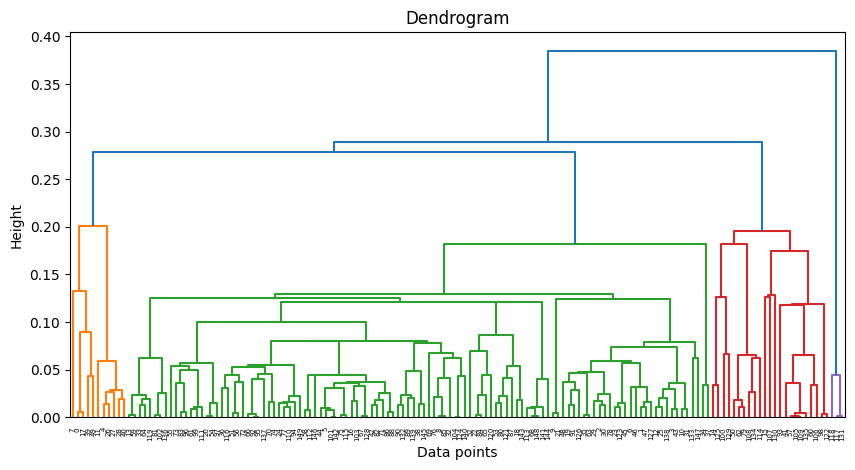

k = 30


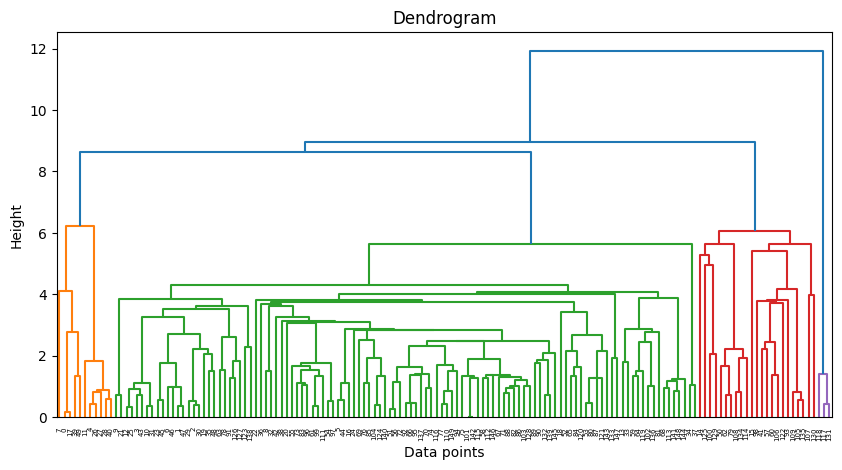

k = 1


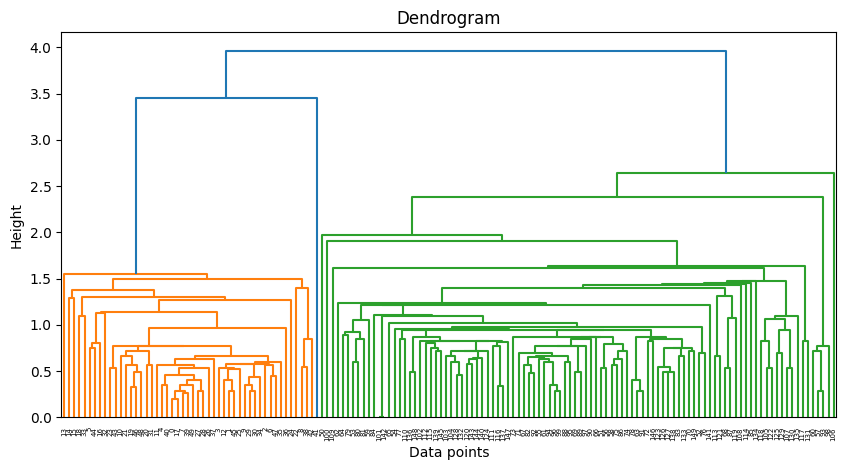

k = 0.05


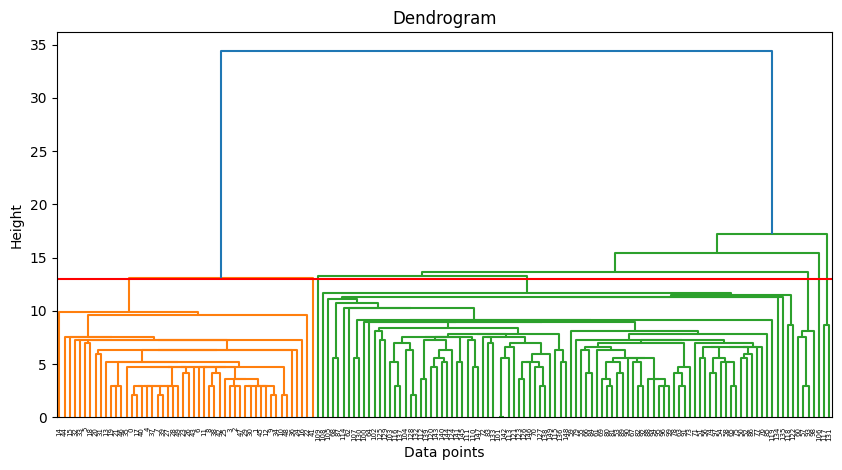

Фильтрация только по расстоянию


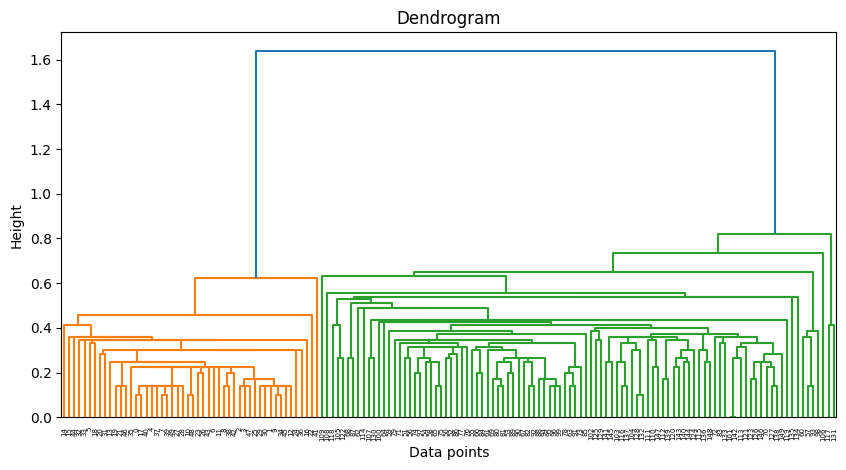

In [5]:
from sklearn.datasets import load_iris

iris = load_iris()
data, y = iris.data, iris.target
K = len(data)
print(K)

fb = FiltrationBuilder(data)
filtration1 = fb.get_filtration_from_density('gaussian', 0.5)
filtration2 = fb.get_filtration_from_scipy_dist('euclidean')


filtration1 = [list(item) for item in filtration1]
max1 = max(item[1] for item in filtration1)
max2 = max(item[1] for item in filtration2)

for i in range(len(filtration1)):
    filtration1[i][1] = (filtration1[i][1] / max1) * max2

filtration1 = [tuple(item) for item in filtration1]
linkage_matrixs = []

print("Фильтрация только по плотности")
lm_density = ClusteringUtils.get_linkage_matrix(filtration1, K)
linkage_matrixs.append(lm_density)
ClusteringUtils.plot_merge_tree(lm_density, 13)

bf_processor = BifiltrationProcessor(filtration1, filtration2)

for k in [30, 1, 0.05]:
    f = lambda x: k * x
    g = lambda y: y / k

    slice_filtration = bf_processor.get_slice_optimized(f, g)

    lm_slice = ClusteringUtils.get_linkage_matrix(slice_filtration, K)
    linkage_matrixs.append(lm_slice)

    print(f"k = {k}")
    ClusteringUtils.plot_merge_tree(lm_slice, 13)

print("Фильтрация только по расстоянию")
lm_distance = ClusteringUtils.get_linkage_matrix(filtration2, K)
linkage_matrixs.append(lm_distance)
ClusteringUtils.plot_merge_tree(lm_distance, 13)

In [6]:
K = len(data)
labels = [str(i) for i in range(K)]
n_clusterings = len(linkage_matrixs)
A = np.zeros((n_clusterings, n_clusterings, 3))

for i in range(5):
    for j in range(i + 1, 5):
        comparator = TreeComparator(linkage_matrixs[i], linkage_matrixs[j], labels)

        rf, max_rf = comparator.compute_rf_distance()
        zss_ted = comparator.compute_zss_tree_edit_distance()
        custom_ted = comparator.compute_custom_tree_edit_distance()
        A[i,j,0] = rf/max_rf
        A[i,j,1] = zss_ted
        A[i,j,2] = custom_ted

        print(f"Расстояние между {i+1} и {j+1} деревьями")
        print(f"RF distance: {rf/max_rf:.4f}")
        print(f"ZSS Tree Edit Distance: {zss_ted}")
        print(f"Custom Tree Edit Distance: {custom_ted}\n")

Расстояние между 1 и 2 деревьями
RF distance: 0.5608
ZSS Tree Edit Distance: 366.0
Custom Tree Edit Distance: 323.1610643496429

Расстояние между 1 и 3 деревьями
RF distance: 0.9459
ZSS Tree Edit Distance: 475.0
Custom Tree Edit Distance: 130.80688519984935

Расстояние между 1 и 4 деревьями
RF distance: 0.9730
ZSS Tree Edit Distance: 490.0
Custom Tree Edit Distance: 945.1726698656918

Расстояние между 1 и 5 деревьями
RF distance: 0.9730
ZSS Tree Edit Distance: 487.0
Custom Tree Edit Distance: 48.069124062742716

Расстояние между 2 и 3 деревьями
RF distance: 0.9257
ZSS Tree Edit Distance: 477.0
Custom Tree Edit Distance: 401.35675201171375

Расстояние между 2 и 4 деревьями
RF distance: 0.9662
ZSS Tree Edit Distance: 479.0
Custom Tree Edit Distance: 1067.8411898950567

Расстояние между 2 и 5 деревьями
RF distance: 0.9662
ZSS Tree Edit Distance: 471.0
Custom Tree Edit Distance: 361.13903211880177

Расстояние между 3 и 4 деревьями
RF distance: 0.7905
ZSS Tree Edit Distance: 438.0
Custom Tr

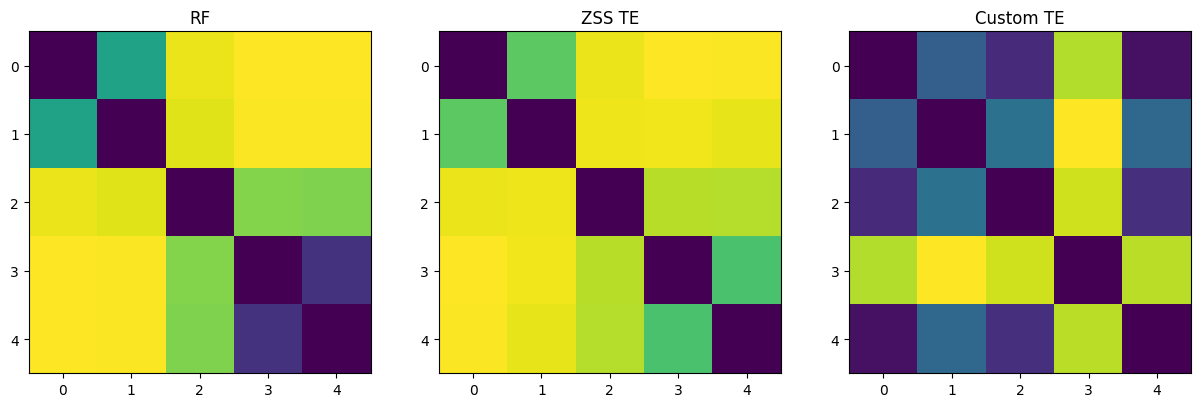

In [ ]:
for ii in range(3):
    A[:,:,ii] = A[:,:,ii] + A[:,:,ii].T
fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
ax[0].set_title("RF")
ax[1].set_title("ZSS TE")
ax[2].set_title("Custom TE")
for ii in range(3):
    ax[ii].imshow(A[:,:,ii], vmin=0)
plt.show()

Фильтрация только по плотности


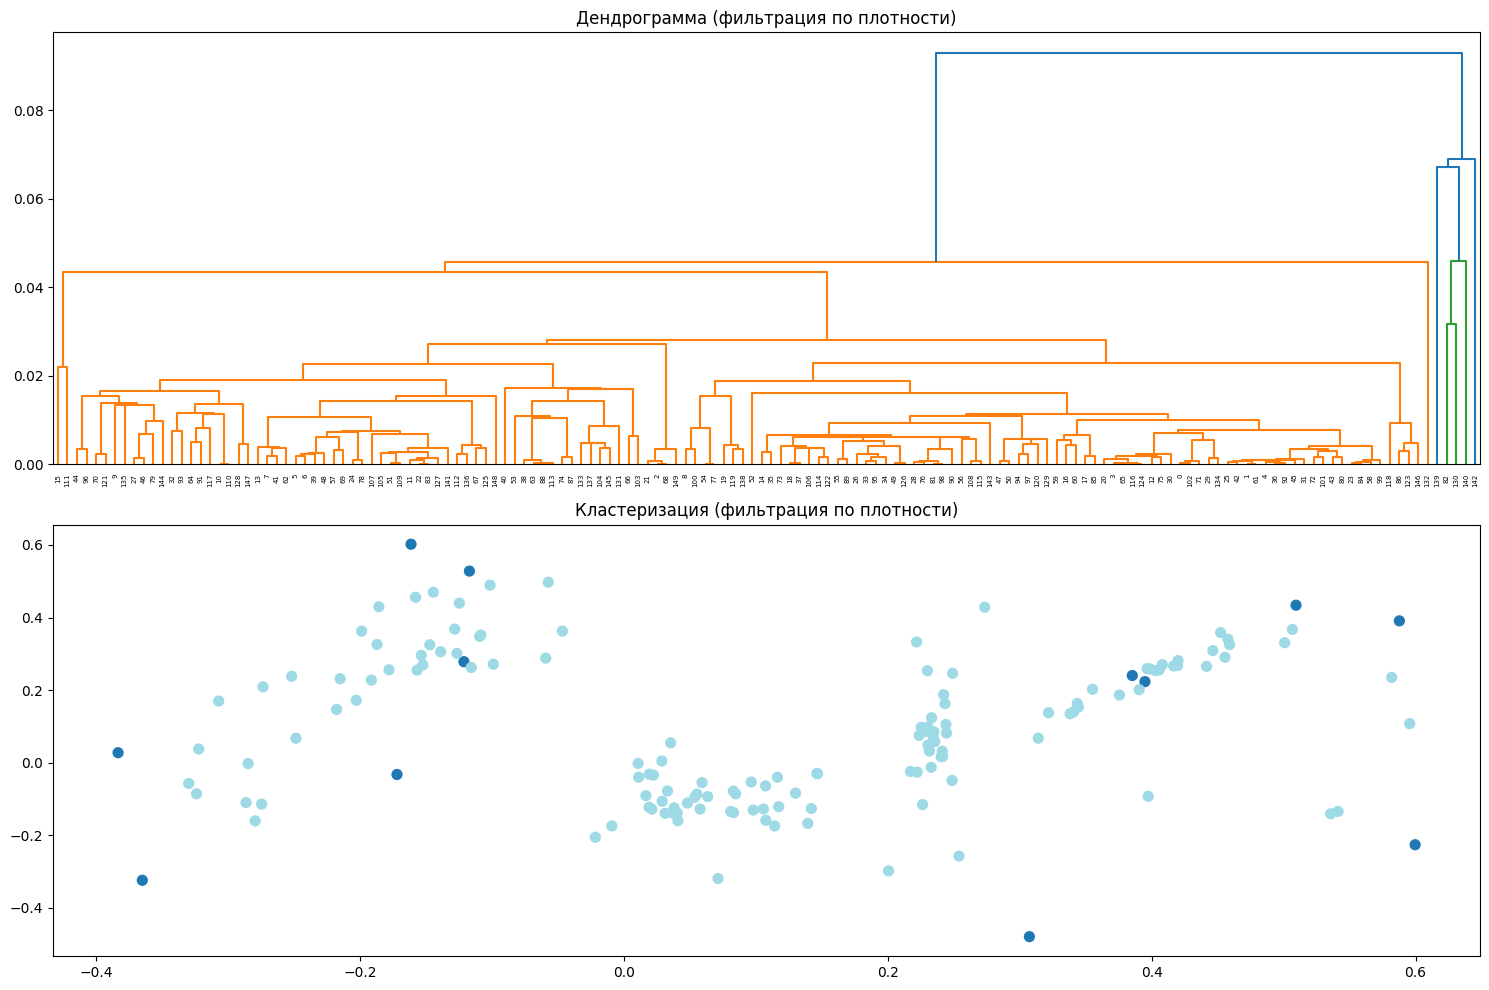

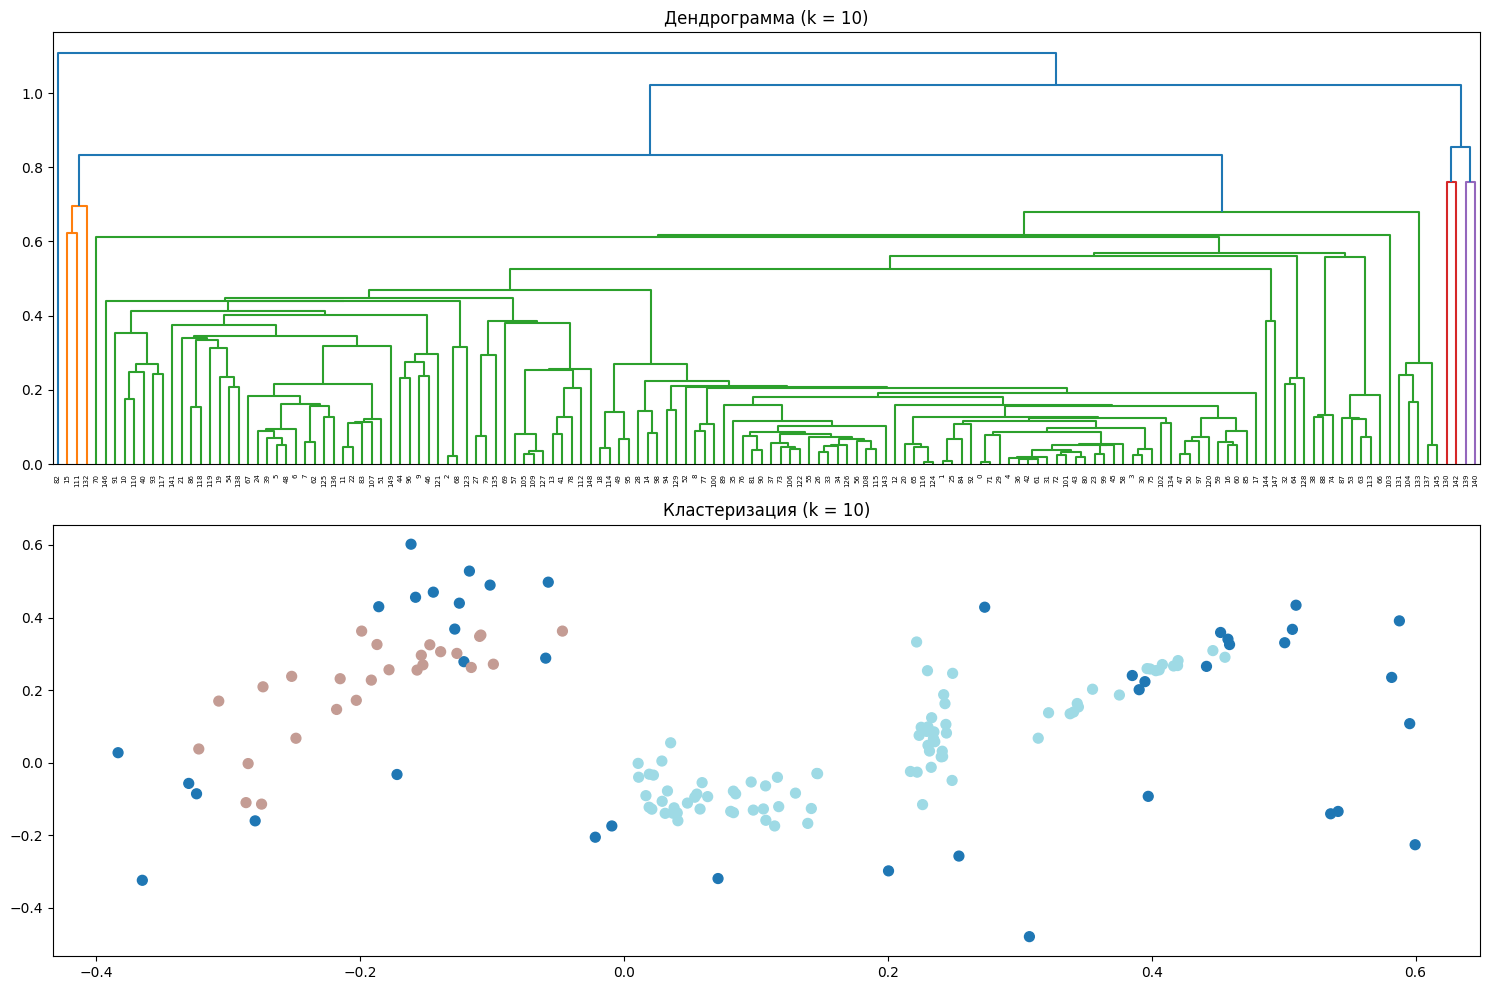

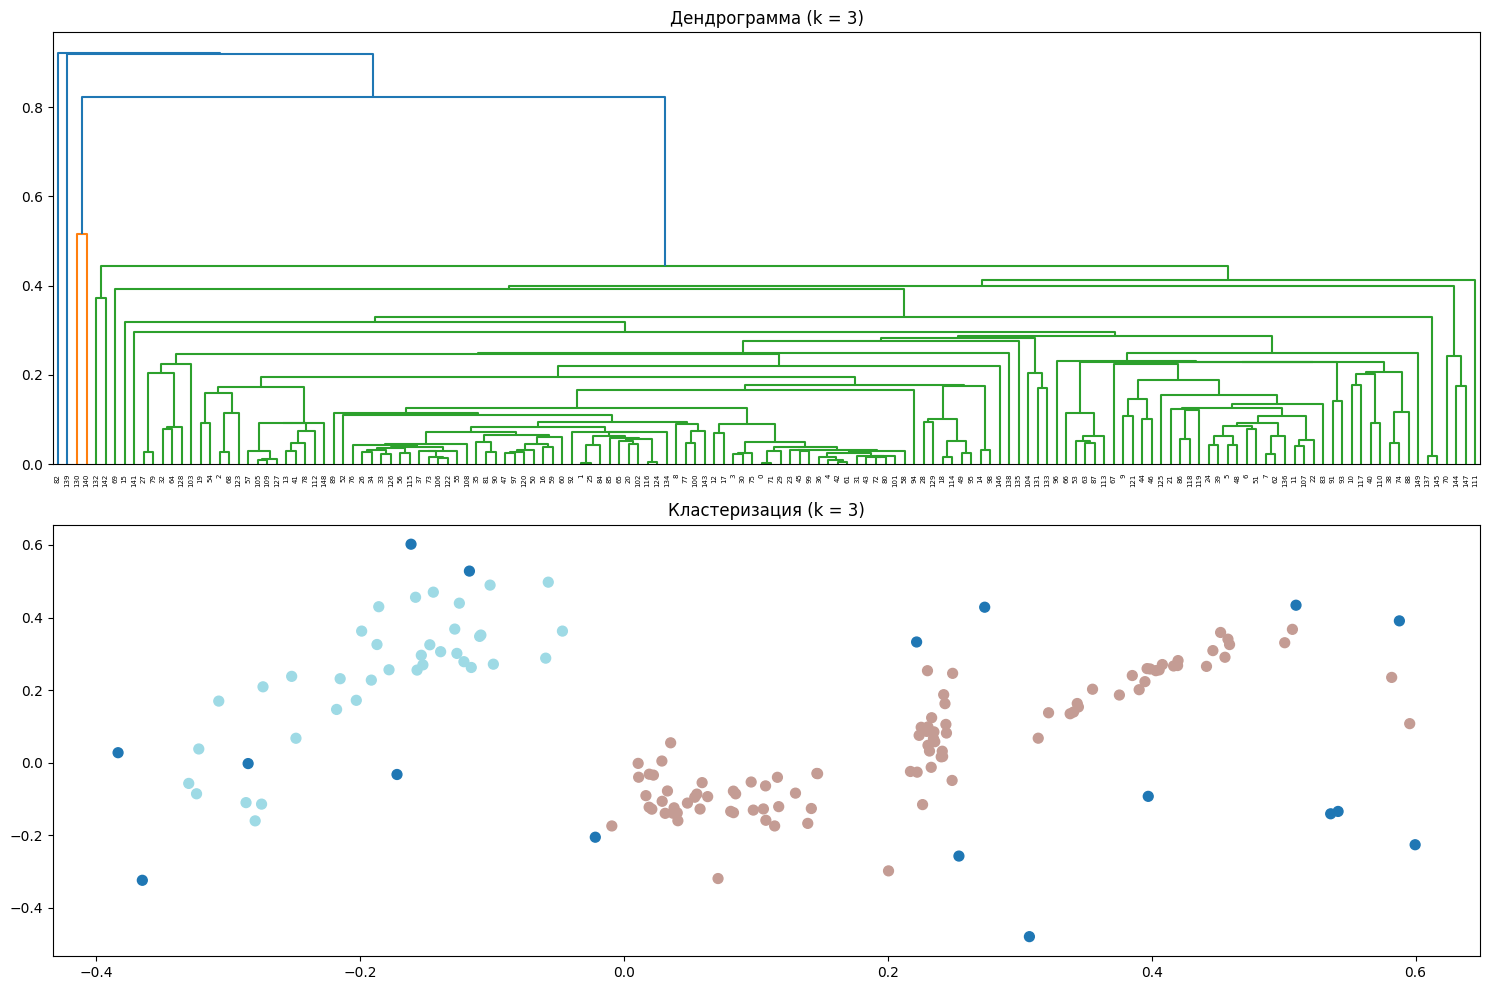

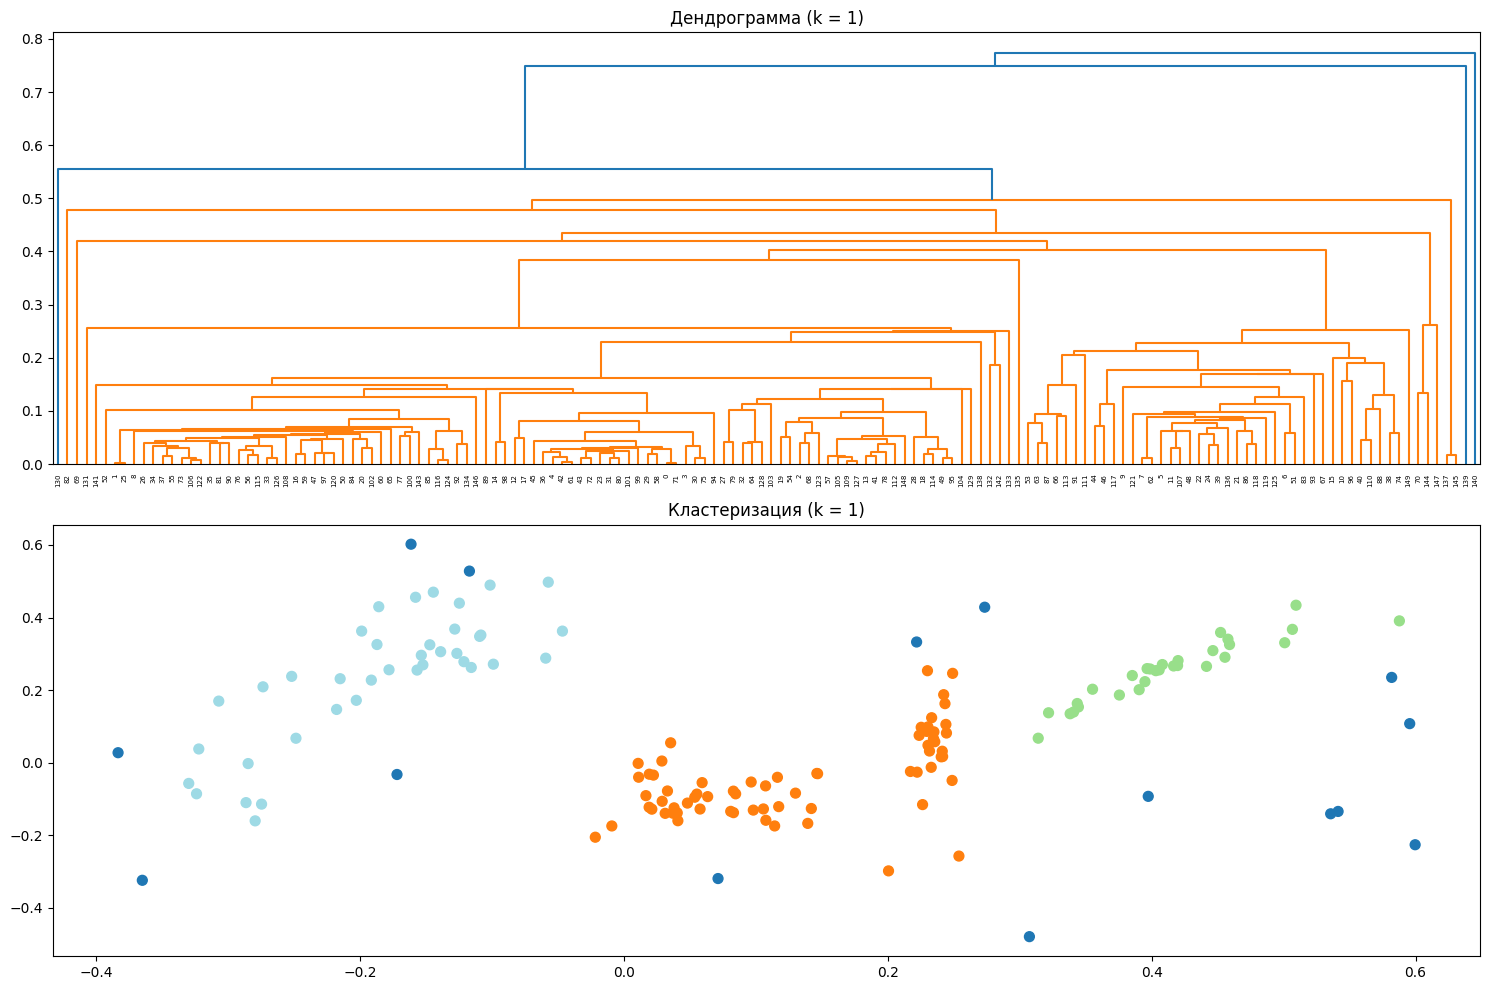

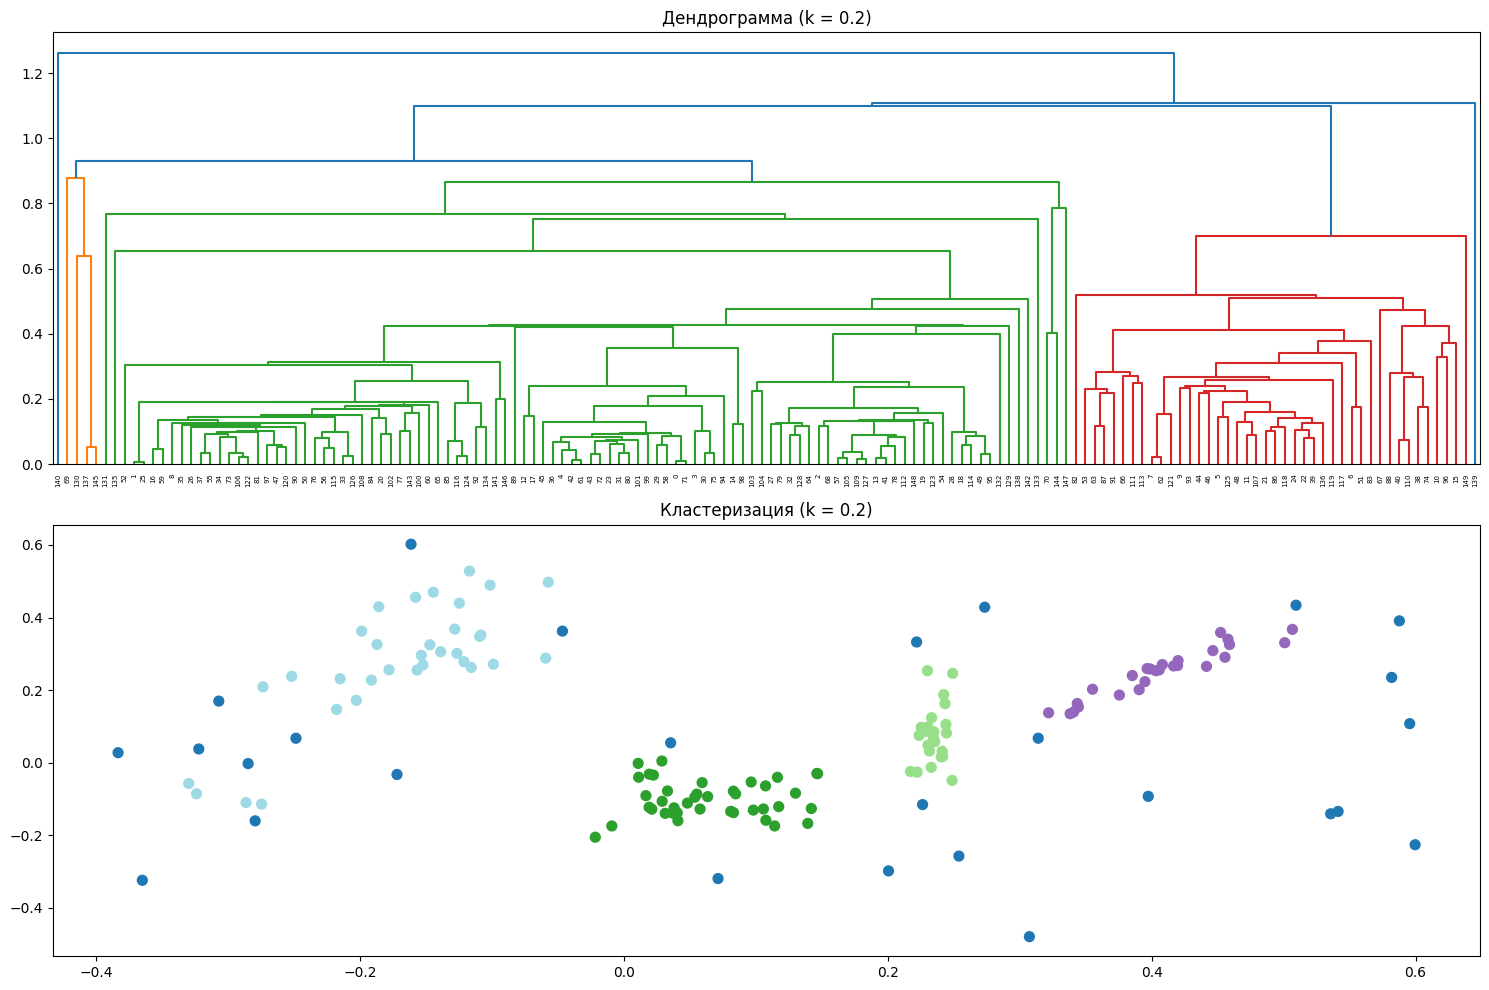

Фильтрация только по расстоянию


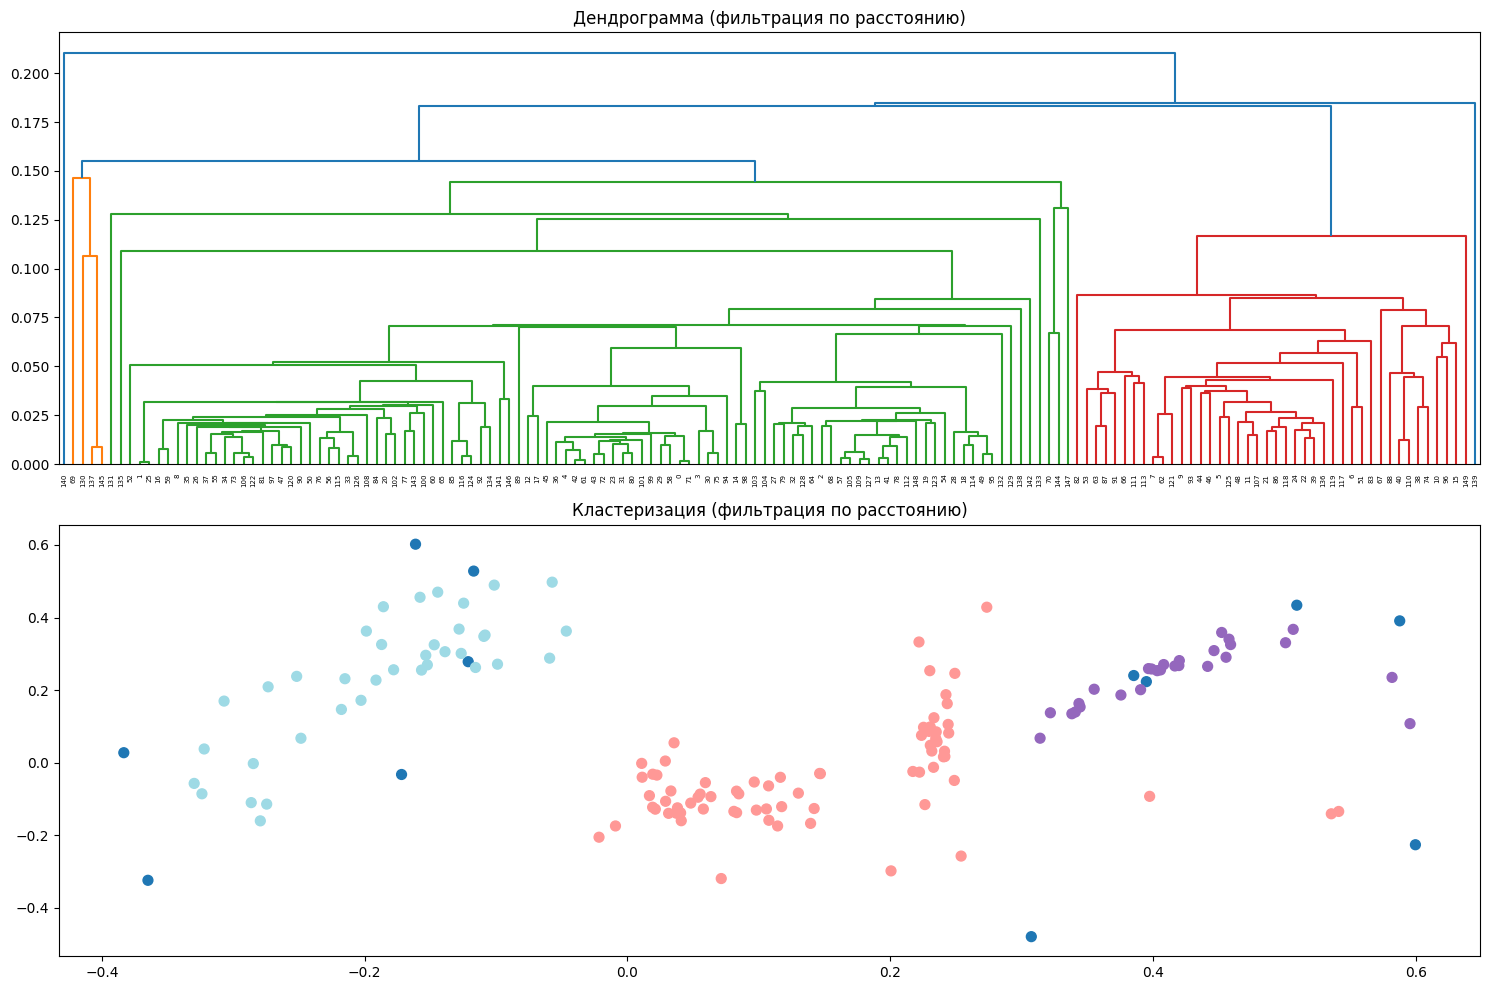

In [71]:
import numpy as np
import random
from sklearn.neighbors import KernelDensity

data = np.load('X_hdbscan.npy')
np.random.seed(0)
random_sample1 = random.sample(data.tolist()[400:1500], 130)
random_sample2 = random.sample(data.tolist()[1900:2300], 20)
combined_data = random_sample1 + random_sample2
data = np.array(combined_data)
K = len(data)

fb = FiltrationBuilder(data)

filtration1 = fb.get_filtration_from_density('gaussian', 0.5)
filtration2 = fb.get_filtration_from_scipy_dist('euclidean')
filtration1 = [list(item) for item in filtration1]
max1 = max(item[1] for item in filtration1)
max2 = max(item[1] for item in filtration2)

for i in range(len(filtration1)):
    filtration1[i][1] = (filtration1[i][1] / max1) * max2

filtration1 = [tuple(item) for item in filtration1]

linkage_matrixs1 = []


print("Фильтрация только по плотности")
lm_density = ClusteringUtils.get_linkage_matrix(filtration1, K)
linkage_matrixs1.append(lm_density)
labels = fcluster(lm_density, t=7, criterion='maxclust')
labels = ClusteringUtils.merge_clusters(data, labels, lm_density, 10, squareform(pdist(data)))
noise = ClusteringUtils.find_persistent_noise(filtration1, K)
for i in noise:
  labels[i] = -1

plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
dendrogram(lm_density)
plt.axhline(y=13, color='r', linestyle='--')
plt.title("Дендрограмма (фильтрация по плотности)")

plt.subplot(2, 1, 2)
plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='tab20', s=50)
plt.title("Кластеризация (фильтрация по плотности)")
plt.tight_layout()
plt.show()

bf_processor = BifiltrationProcessor(filtration1, filtration2)

for k in [10, 3, 1, 0.2]:
    f = lambda x: k * x
    g = lambda y: y / k

    slice_filtration = bf_processor.get_slice_optimized(f, g)

    lm_slice = ClusteringUtils.get_linkage_matrix(slice_filtration, K)
    linkage_matrixs1.append(lm_slice)
    labels = fcluster(lm_slice, t=30, criterion='maxclust')
    labels = ClusteringUtils.merge_clusters(data, labels, lm_slice, 10, squareform(pdist(data)))
    noise = ClusteringUtils.find_persistent_noise(slice_filtration, K)
    for i in noise:
      labels[i] = -1

    plt.figure(figsize=(15, 10))

    plt.subplot(2, 1, 1)
    dendrogram(lm_slice)
    plt.axhline(y=13, color='r', linestyle='--')
    plt.title(f"Дендрограмма (k = {k})")

    plt.subplot(2, 1, 2)
    plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='tab20', s=50)
    plt.title(f"Кластеризация (k = {k})")
    plt.tight_layout()
    plt.show()

print("Фильтрация только по расстоянию")
lm_distance = ClusteringUtils.get_linkage_matrix(filtration2, K)
linkage_matrixs1.append(lm_distance)
labels = fcluster(lm_distance, t=20, criterion='maxclust')
labels = ClusteringUtils.merge_clusters(data, labels, lm_distance, 10, squareform(pdist(data)))
noise = ClusteringUtils.find_persistent_noise(filtration1, K)
for i in noise:
  labels[i] = -1

plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
dendrogram(lm_distance)
plt.axhline(y=13, color='r', linestyle='--')
plt.title("Дендрограмма (фильтрация по расстоянию)")

plt.subplot(2, 1, 2)
plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='tab20', s=50)
plt.title("Кластеризация (фильтрация по расстоянию)")
plt.tight_layout()
plt.show()

In [ ]:
K = len(data)
labels = [str(i) for i in range(K)]
n_clusterings = len(linkage_matrixs1)
A = np.zeros((n_clusterings, n_clusterings, 3))

for i in range(6):
    for j in range(i + 1, 6):
        comparator = TreeComparator(linkage_matrixs1[i], linkage_matrixs1[j], labels)
        rf, max_rf = comparator.compute_rf_distance()
        zss_ted = comparator.compute_zss_tree_edit_distance()
        custom_ted = comparator.compute_custom_tree_edit_distance()
        A[i,j,0] = rf/max_rf
        A[i,j,1] = zss_ted
        A[i,j,2] = custom_ted

        print(f"Расстояние между {i+1} и {j+1} деревьями")
        print(f"Нормализованное RF расстояние: {rf/max_rf:.4f}")
        print(f"ZSS Tree Edit Distance: {zss_ted}")
        print(f"Custom Tree Edit Distance: {custom_ted}\n")

Расстояние между 1 и 2 деревьями
Нормализованное RF расстояние: 0.8378
ZSS Tree Edit Distance: 439.0
Custom Tree Edit Distance: 24.261317395449236

Расстояние между 1 и 3 деревьями
Нормализованное RF расстояние: 0.9392
ZSS Tree Edit Distance: 475.0
Custom Tree Edit Distance: 13.688848228035917

Расстояние между 1 и 4 деревьями
Нормализованное RF расстояние: 0.9527
ZSS Tree Edit Distance: 488.0
Custom Tree Edit Distance: 10.559309498806597

Расстояние между 1 и 5 деревьями
Нормализованное RF расстояние: 0.9662
ZSS Tree Edit Distance: 480.0
Custom Tree Edit Distance: 23.783928327169267

Расстояние между 1 и 6 деревьями
Нормализованное RF расстояние: 0.9662
ZSS Tree Edit Distance: 480.0
Custom Tree Edit Distance: 3.9664786103983234

Расстояние между 2 и 3 деревьями
Нормализованное RF расстояние: 0.6284
ZSS Tree Edit Distance: 483.0
Custom Tree Edit Distance: 22.680208051940426

Расстояние между 2 и 4 деревьями
Нормализованное RF расстояние: 0.8041
ZSS Tree Edit Distance: 490.0
Custom Tree

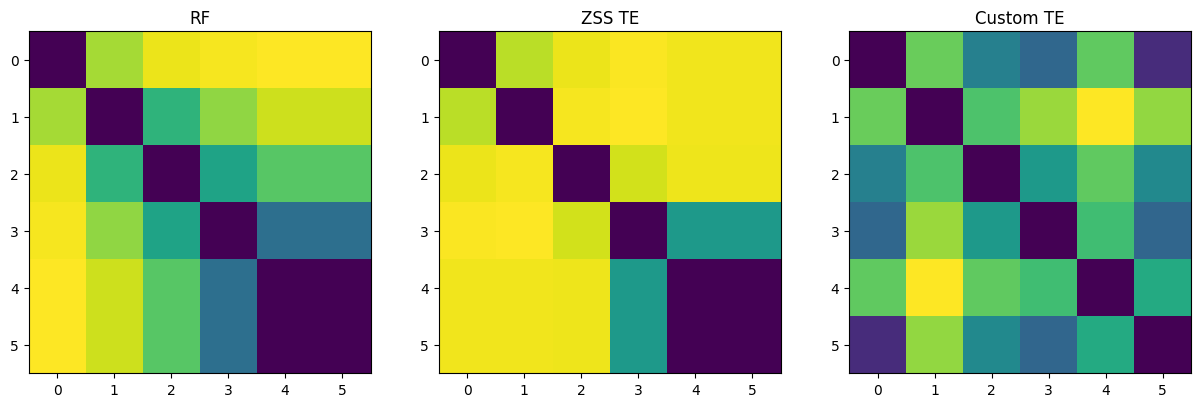

In [ ]:
for ii in range(3):
    A[:,:,ii] = A[:,:,ii] + A[:,:,ii].T
fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
ax[0].set_title("RF")
ax[1].set_title("ZSS TE")
ax[2].set_title("Custom TE")
for ii in range(3):
    ax[ii].imshow(A[:,:,ii], vmin=0)
plt.show()

Фильтрация только по плотности


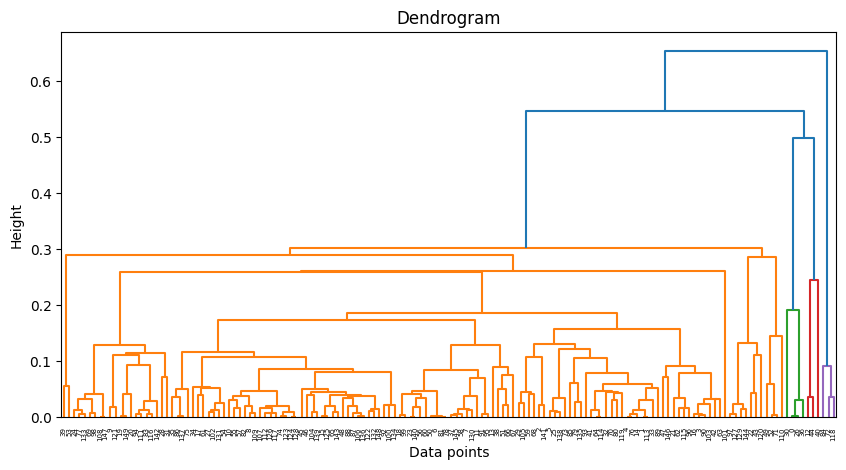

k = 15


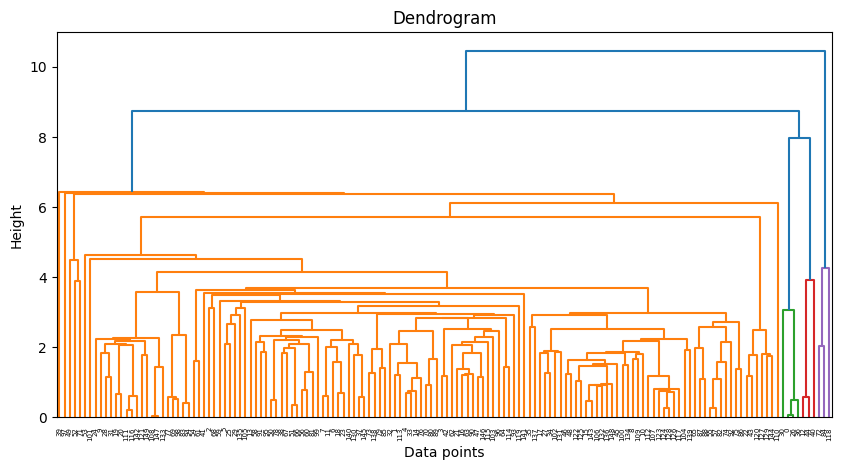

k = 10


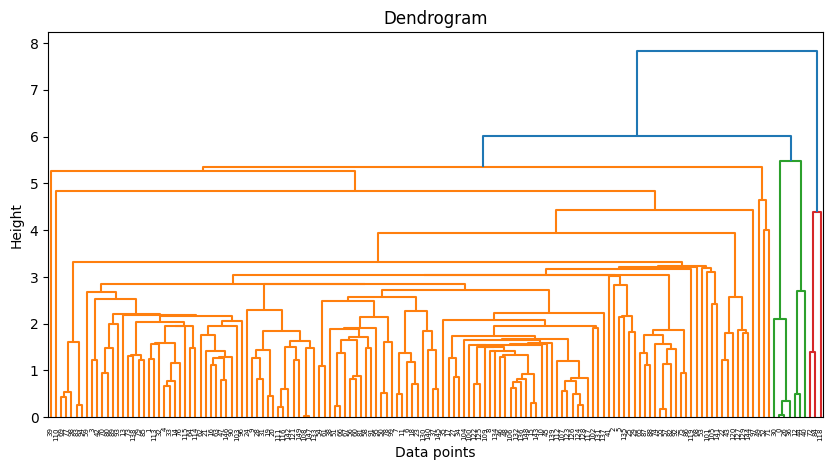

k = 3


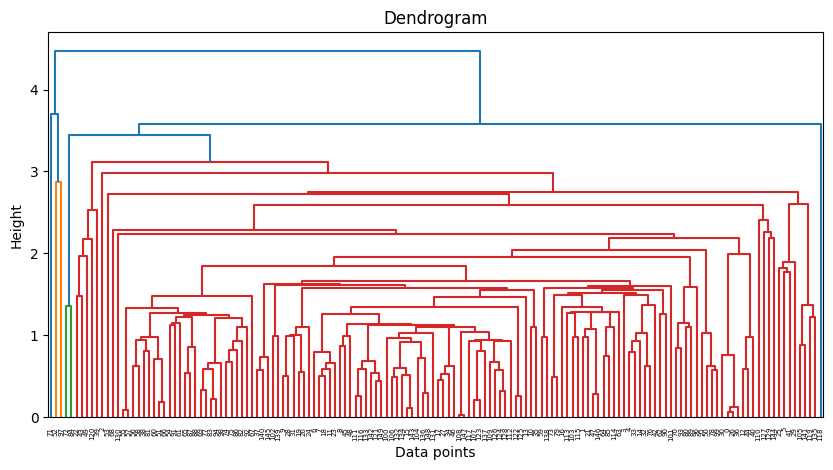

k = 0.05


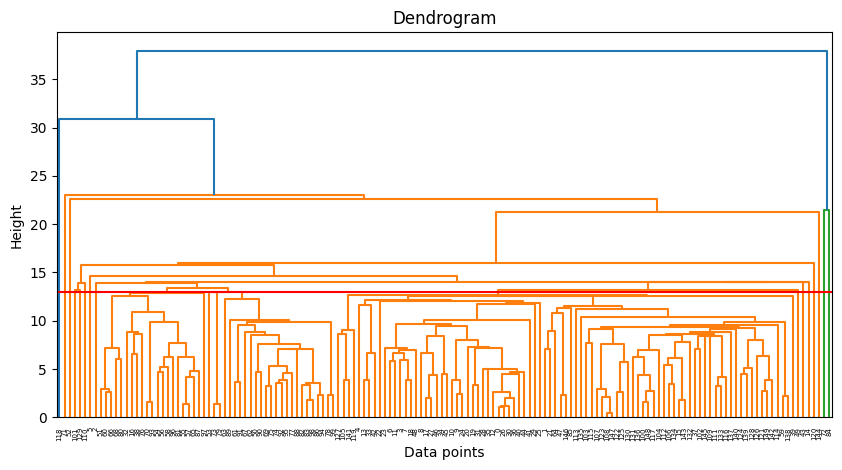

Фильтрация только по расстоянию


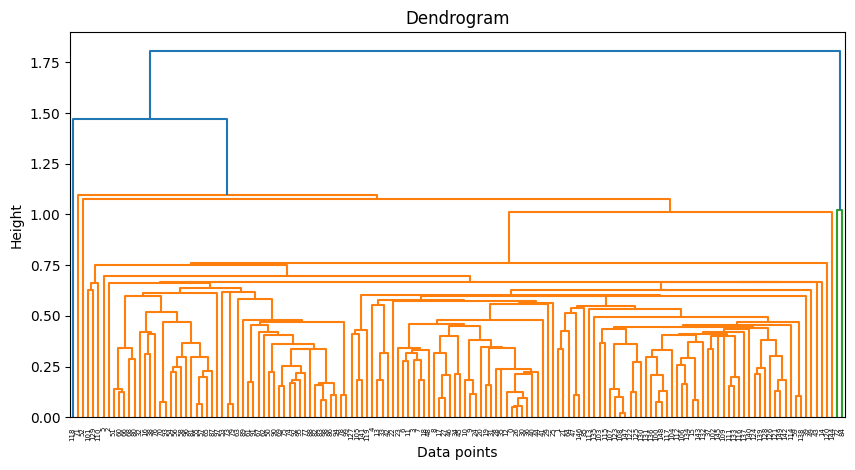

In [ ]:
import numpy as np
from sklearn.neighbors import KernelDensity

mean1, cov1 = [0, 0], [[1, 0.5], [0.5, 1]]
mean2, cov2 = [3, 3], [[1, -0.5], [-0.5, 1]]
mean3, cov3 = [-1, 3], [[1, 0], [0, 1]]
n_points = 50

np.random.seed(2)
data1 = np.random.multivariate_normal(mean1, cov1, n_points)
data2 = np.random.multivariate_normal(mean2, cov2, n_points)
data3 = np.random.multivariate_normal(mean3, cov3, n_points)
data = np.vstack((data1, data2, data3))
K = len(data)

fb = FiltrationBuilder(data)

filtration1 = fb.get_filtration_from_density('exponential', 0.5)
filtration2 = fb.get_filtration_from_scipy_dist('euclidean')
filtration1 = [list(item) for item in filtration1]
max1 = max(item[1] for item in filtration1)
max2 = max(item[1] for item in filtration2)

for i in range(len(filtration1)):
    filtration1[i][1] = (filtration1[i][1] / max1) * max2

filtration1 = [tuple(item) for item in filtration1]

linkage_matrixs1 = []

print("Фильтрация только по плотности")
lm_density = ClusteringUtils.get_linkage_matrix(filtration1, K)
linkage_matrixs1.append(lm_density)
ClusteringUtils.plot_merge_tree(lm_density, 13)

bf_processor = BifiltrationProcessor(filtration1, filtration2)

for k in [15, 10, 3, 0.05]:
    f = lambda x: k * x
    g = lambda y: y / k

    slice_filtration = bf_processor.get_slice_optimized(f, g)

    lm_slice = ClusteringUtils.get_linkage_matrix(slice_filtration, K)
    linkage_matrixs1.append(lm_slice)

    print(f"k = {k}")
    ClusteringUtils.plot_merge_tree(lm_slice, 13)

print("Фильтрация только по расстоянию")
lm_distance = ClusteringUtils.get_linkage_matrix(filtration2, K)
linkage_matrixs1.append(lm_distance)
ClusteringUtils.plot_merge_tree(lm_distance, 13)

In [ ]:
K = len(data)
labels = [str(i) for i in range(K)]
n_clusterings = len(linkage_matrixs1)
A = np.zeros((n_clusterings, n_clusterings, 3))

for i in range(6):
    for j in range(i + 1, 6):
        comparator = TreeComparator(linkage_matrixs1[i], linkage_matrixs1[j], labels)

        rf, max_rf = comparator.compute_rf_distance()
        zss_ted = comparator.compute_zss_tree_edit_distance()
        custom_ted = comparator.compute_custom_tree_edit_distance()
        A[i,j,0] = rf/max_rf
        A[i,j,1] = zss_ted
        A[i,j,2] = custom_ted

        print(f"Расстояние между {i+1} и {j+1} деревьями")
        print(f"Нормализованное RF расстояние: {rf/max_rf:.4f}")
        print(f"ZSS Tree Edit Distance: {zss_ted}")
        print(f"Custom Tree Edit Distance: {custom_ted}\n")

Расстояние между 1 и 2 деревьями
Нормализованное RF расстояние: 0.7568
ZSS Tree Edit Distance: 446.0
Custom Tree Edit Distance: 333.34893416491866

Расстояние между 1 и 3 деревьями
Нормализованное RF расстояние: 0.8378
ZSS Tree Edit Distance: 458.0
Custom Tree Edit Distance: 268.9051807624078

Расстояние между 1 и 4 деревьями
Нормализованное RF расстояние: 0.9122
ZSS Tree Edit Distance: 476.0
Custom Tree Edit Distance: 184.44589964049817

Расстояние между 1 и 5 деревьями
Нормализованное RF расстояние: 0.9527
ZSS Tree Edit Distance: 500.0
Custom Tree Edit Distance: 1197.4700264413893

Расстояние между 1 и 6 деревьями
Нормализованное RF расстояние: 0.9527
ZSS Tree Edit Distance: 500.0
Custom Tree Edit Distance: 60.210897964257676

Расстояние между 2 и 3 деревьями
Нормализованное RF расстояние: 0.4189
ZSS Tree Edit Distance: 401.0
Custom Tree Edit Distance: 368.792845827524

Расстояние между 2 и 4 деревьями
Нормализованное RF расстояние: 0.7973
ZSS Tree Edit Distance: 470.0
Custom Tree Ed

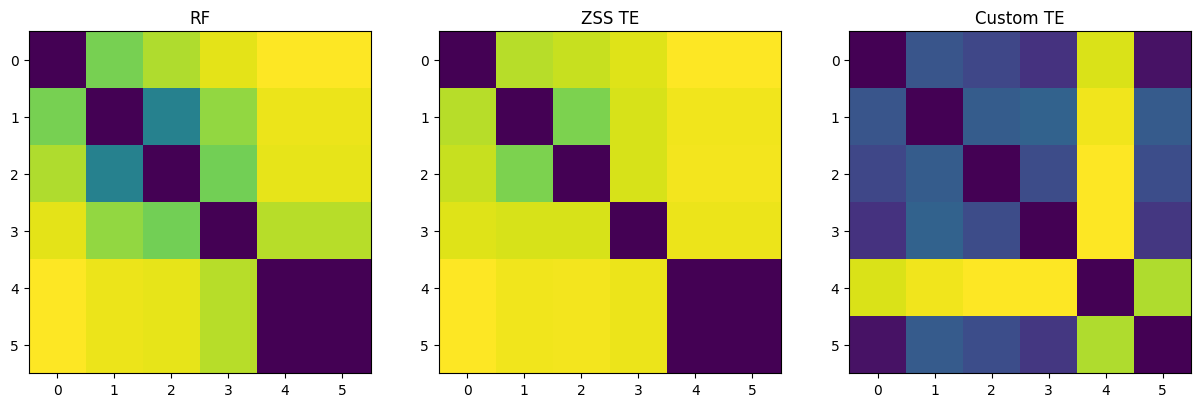

In [ ]:
for ii in range(3):
    A[:,:,ii] = A[:,:,ii] + A[:,:,ii].T
fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
ax[0].set_title("RF")
ax[1].set_title("ZSS TE")
ax[2].set_title("Custom TE")
for ii in range(3):
    ax[ii].imshow(A[:,:,ii], vmin=0)
plt.show()